<a href="https://colab.research.google.com/github/bobbercheng/ventilator-pressure-prediction/blob/master/ventilator_pressure_transformer_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

V1: Add PositionalEncoding

V2: Adjust Transformer parameters

In [2]:
# Update pandas version for Colab TPU
#!pip install pandas==1.3.2

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [4]:
if IN_COLAB:
  from google.colab import drive
  drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [5]:
if IN_COLAB:
  !pip install kaggle
  !mkdir /root/.kaggle
  !cp /gdrive/MyDrive/ventilator-pressure-prediction/kaggle.json /root/.kaggle
  !kaggle competitions download -c ventilator-pressure-prediction
  !mkdir -p /kaggle/input/ventilator-pressure-prediction
  !unzip '*.zip' -d /kaggle/input/ventilator-pressure-prediction
  !ls /kaggle/input/ventilator-pressure-prediction

  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 78.6MB/s]
 98% 137M/139M [00:03<00:00, 69.2MB/s]
100% 139M/139M [00:03<00:00, 43.9MB/s]
 82% 62.0M/75.4M [00:02<00:00, 21.2MB/s]
100% 75.4M/75.4M [00:02<00:00, 33.4MB/s]
Archive:  sample_submission.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/sample_submission.csv  

Archive:  test.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/test.csv  

Archive:  train.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/train.csv  

3 archives were successfully processed.
sample_submission.csv  test.csv  train.csv


In [6]:
import numpy as np
import pandas as pd

# import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

model_folder = '/gdrive/MyDrive/ventilator-pressure-prediction/transformer/'

EPOCH = 300
BATCH_SIZE = 512
NUM_FOLDS = 10

TRANSFORMER_HEAD_SIZES=[512, 256, 128, 64]
TRANSFORMER_OUTPUT_DIMS=[None, None, None, None]
TRANSFORMER_NUM_HEADS=[8, 8, 4, 4]
TRANSFORMER_FF_DIMS=128,
TRANSFORMER_NUM_TRANSFORMER_BLOCKS=4
TRANSFORMER_MLP_UNITS=[32]
TRANSFORMER_DROPOUT=0.01
TRANSFORMER_MLP_DROPOUT=0.01

In [7]:
import os
import random
# Deep Learning
import tensorflow as tf
from tensorflow import keras
# Metrics
from sklearn.metrics import mean_absolute_error

# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything()

In [8]:
DEBUG = False

train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/sample_submission.csv')

if DEBUG:
    train = train[:80*1000]

In [9]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-5...Completed")
    
    return df


train = add_features(train)
test = add_features(test)

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed


In [10]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

train.head(), train.shape

(   time_step       u_in  u_out  ...  R__C_5__10  R__C_5__20  R__C_5__50
 0   0.000000   0.083334      0  ...           0           0           0
 1   0.033652  18.383041      0  ...           0           0           0
 2   0.067514  22.509278      0  ...           0           0           0
 3   0.101542  22.808822      0  ...           0           0           0
 4   0.135756  25.355850      0  ...           0           0           0
 
 [5 rows x 53 columns], (6036000, 53))

In [11]:
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [12]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

In [13]:
from tensorflow.keras import layers
from tensorflow import keras

In [14]:
# refer to https://www.tensorflow.org/text/tutorials/transformer#encoder
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def get_positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [45]:
#refer to https://keras.io/examples/timeseries/timeseries_classification_transformer/
def transformer_encoder(inputs, head_size, num_heads, output_dim, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    if head_size == -1:
      head_size = inputs.shape[-1]
    print(head_size, num_heads, output_dim, dropout)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, output_shape=output_dim, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    # Feed forward can be Den lay or RNN as long as it keep final dimension
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [56]:
# refer to https://www.tensorflow.org/text/tutorials/transformer#encoder
# https://rubikscode.net/2019/08/19/transformer-with-python-and-tensorflow-2-0-encoder-decoder/
# https://trungtran.io/2019/04/29/create-the-transformer-with-tensorflow-2-0/
# https://github.com/ChunML/NLP/blob/master/chatbot/model.py
def build_transfer_model(
    input_shape,
    head_sizes=TRANSFORMER_HEAD_SIZES,
    output_dims=TRANSFORMER_OUTPUT_DIMS,
    num_heads=TRANSFORMER_NUM_HEADS,
    ff_dims=TRANSFORMER_FF_DIMS,
    num_transformer_blocks=TRANSFORMER_NUM_TRANSFORMER_BLOCKS,
    mlp_units=TRANSFORMER_MLP_UNITS,
    dropout=TRANSFORMER_DROPOUT,
    mlp_dropout=TRANSFORMER_MLP_DROPOUT,
):

    inputs = keras.Input(shape=input_shape)
    time_lenght = input_shape[0]
    positional_encoding = get_positional_encoding(time_lenght, input_shape[-1])
    print('positional_encoding:', positional_encoding)

    x = inputs

    # increase x then add position encoding.
    '''
    The reason we increase the embedding values before the addition is to make 
    the positional encoding relatively smaller. This means the original meaning 
    in the embedding vector won’t be lost when we add them together.
    '''
    x *= tf.math.sqrt(tf.cast(input_shape[-1], tf.float32))
    x += positional_encoding[:, :time_lenght, :]

    for head_size, num_head, output_dim in zip(head_sizes, num_heads, output_dims):
        x = transformer_encoder(x, head_size, num_head, output_dim, ff_dims, dropout)

    x_pool = layers.GlobalAveragePooling1D(data_format="channels_first", keepdims=True)(x)

    x = layers.Concatenate()([x, x_pool])

    for dim in mlp_units:
        x = layers.Dense(dim, activation="selu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)


    model = keras.Model(inputs, outputs)
    model.summary()
    return model

positional_encoding: tf.Tensor(
[[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    1.0000000e+00  0.0000000e+00]
  [ 8.4147096e-01  5.4030228e-01  6.4910674e-01 ...  1.6842831e-04
    1.0000000e+00  1.1897938e-04]
  [ 9.0929741e-01 -4.1614684e-01  9.8754758e-01 ...  3.3685661e-04
    9.9999994e-01  2.3795875e-04]
  ...
  [ 9.9952018e-01 -3.0975033e-02 -8.3408141e-01 ...  1.2968617e-02
    9.9991590e-01  9.1612842e-03]
  [ 5.1397848e-01 -8.5780311e-01 -9.9255764e-01 ...  1.3137030e-02
    9.9991369e-01  9.2802588e-03]
  [-4.4411266e-01 -8.9597094e-01 -6.7599046e-01 ...  1.3305444e-02
    9.9991149e-01  9.3992325e-03]]], shape=(1, 80, 53), dtype=float32)
512 8 None 0.01
256 8 None 0.01
128 4 None 0.01
64 4 None 0.01
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 

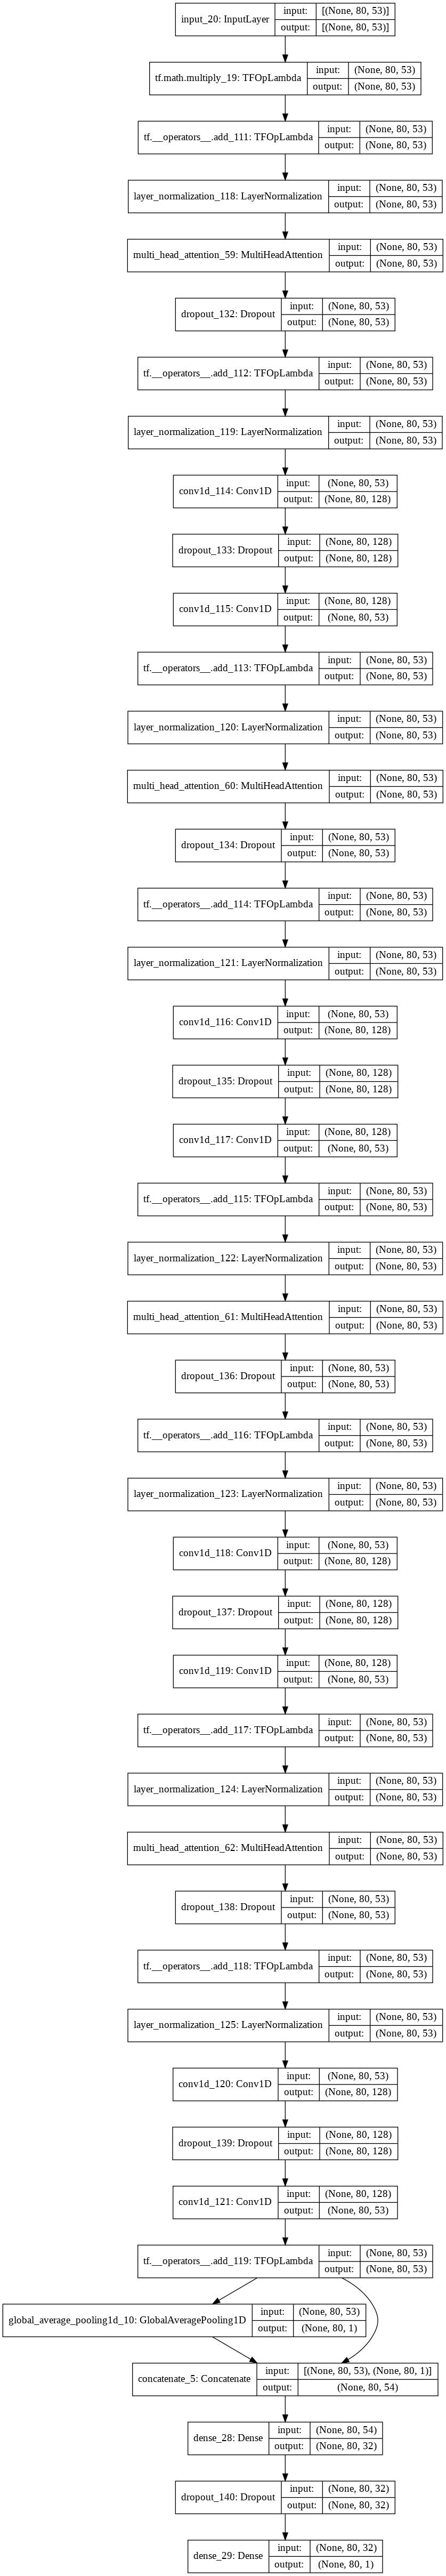

In [57]:
from tensorflow.keras.utils import plot_model
model = build_transfer_model(train.shape[1:])
plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [18]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay


with strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    train_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        #u_out_train, u_out_valid = u_outs[train_idx], u_outs[test_idx]
        
        #model = get_cnn_model(train)
        model = build_transfer_model(train.shape[1:])
        model.compile(optimizer='adam', 
                      # loss=GBVPP_loss,
                      loss="mae"
                      )

        #scheduler = ExponentialDecay(1e-3, 40*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        #lr = LearningRateScheduler(scheduler, verbose=1)
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=10, verbose=1)
        es = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min", restore_best_weights=True)
        checkpoint_filepath = f"folds{fold}.hdf5"
        sv = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
            save_weights_only=False, mode='auto', save_freq='epoch',
            options=None)

        history = model.fit(X_train,
                            y_train,
                            # validation_data=(X_valid, np.append(y_valid, u_out_valid, axis =1)), 
                            validation_data=(X_valid, y_valid), 
                            epochs=EPOCH, 
                            batch_size=1024, 
                            callbacks=[lr,
                                       es,
                                       sv])
        
        if IN_COLAB:
          with open(model_folder+checkpoint_filepath, 'wb') as f:
            f.write(open(checkpoint_filepath, 'rb').read())
    
        test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())
        train_preds.append(model.predict(train).squeeze().reshape(-1, 1).squeeze())


--------------- > Fold 1 < ---------------
positional_encoding: tf.Tensor(
[[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    1.0000000e+00  0.0000000e+00]
  [ 8.4147096e-01  5.4030228e-01  6.4910674e-01 ...  1.6842831e-04
    1.0000000e+00  1.1897938e-04]
  [ 9.0929741e-01 -4.1614684e-01  9.8754758e-01 ...  3.3685661e-04
    9.9999994e-01  2.3795875e-04]
  ...
  [ 9.9952018e-01 -3.0975033e-02 -8.3408141e-01 ...  1.2968617e-02
    9.9991590e-01  9.1612842e-03]
  [ 5.1397848e-01 -8.5780311e-01 -9.9255764e-01 ...  1.3137030e-02
    9.9991369e-01  9.2802588e-03]
  [-4.4411266e-01 -8.9597094e-01 -6.7599046e-01 ...  1.3305444e-02
    9.9991149e-01  9.3992325e-03]]], shape=(1, 80, 53), dtype=float32)
512 8 None 0.01
256 8 None 0.01
128 4 None 0.01
64 4 None 0.01
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                   

In [ ]:
mae(targets, np.median(np.vstack(test_preds),axis=0))

In [ ]:
PRESSURE_STEP = 0.07030214545120961
PRESSURE_MIN = -1.8957442945646408
PRESSURE_MAX = 64.82099173863948

In [ ]:
# ENSEMBLE FOLDS WITH MEAN
submission["pressure"] = sum(test_preds)/NUM_FOLDS
submission.to_csv('submission_mean.csv', index=False)

In [ ]:
# ENSEMBLE FOLDS WITH MEDIAN
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
submission.to_csv('submission_median.csv', index=False)

In [ ]:
# ENSEMBLE FOLDS WITH MEDIAN AND ROUND PREDICTIONS
submission["pressure"] =\
    np.round( (submission.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
submission.pressure = np.clip(submission.pressure, PRESSURE_MIN, PRESSURE_MAX)
submission.to_csv('submission_median_round.csv', index=False)

In [ ]:
if IN_COLAB:
  !zip cnn_models.zip *.hdf5
  !zip submission.zip *.csv
  with open(model_folder + 'submission.zip', 'wb') as f:
    f.write(open('submission.zip', 'rb').read())
  with open(model_folder + 'cnn_models.zip', 'wb') as f:
    f.write(open('cnn_models.zip', 'rb').read())